## Goal: Create a CNN to classify MNIST according to the following specifications:
1. 2 layers of Convolution with filters having: Size of 1 X (5 X 5) X 6 and Size of 6 X (5 X 5) X 10
2. For each layer, use ReLU
3. After the second layer (and after ReLU), use Max Pooling
4. Feed into a fully connected layer (FCC)

The architecture should thus take the following form:

6 Conv1 Filter(s) of size 1 X (5 X 5) ---> ReLU ---> 10 Conv1 Filter(s) of size 6 X (5 X 5) ---> ReLU ---> Max Pooling ---> FCC



In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))  ])

training_data = torchvision.datasets.MNIST(root = './data_MNIST',
                                          download = True,
                                          train = True, 
                                          transform = transform)

test_data = torchvision.datasets.MNIST(root = './data_MNIST',
                                          download = True,
                                          train = False, 
                                          transform = transform)

train_loader = torch.utils.data.DataLoader(training_data, 
                                          batch_size = 4,
                                          shuffle = True,
                                          num_workers = 2)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size = 4,
                                          shuffle = False,
                                          num_workers = 2)

In [91]:
def show_image(img):
    img = img*0.3081 + 0.1307
    img = img.numpy()
    plt.imshow(np.transpose(img,(1,2,0)))

In [4]:
dataiter = iter(train_loader)
img, labels = dataiter.next()

(3, 32, 122)
tensor([4, 9, 6, 0])


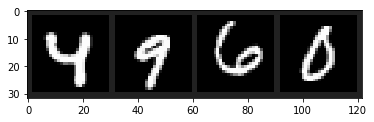

In [5]:
show_image(torchvision.utils.make_grid(img, nrow = 8))
print(labels)

In [47]:
class Net(nn.Module):
    def __init__(self, filter1_width, filter1_height, filter1_depth, filter1_OC,
                filter2_width, filter2_height, filter2_OC,
                FCC_out):
        super(Net,self).__init__()
        self.C1 = nn.Conv2d(in_channels = filter1_depth, 
                           out_channels = filter1_OC,
                           kernel_size = (filter1_height,filter1_width))
        self.C2 = nn.Conv2d(in_channels = filter1_OC, 
                           out_channels = filter2_OC,
                           kernel_size = (filter2_height,filter2_width))
        self.MP = nn.MaxPool2d(kernel_size = 2)
        self.FC_in_dim = (28 - filter1_height - filter2_height + 2)/2
        self.FC = nn.Linear(int(filter2_OC * self.FC_in_dim**2)  ,FCC_out)
        
    def forward(self,x):
        x = self.C1(x)
        x = F.relu(x)
        x = self.C2(x)
        x = F.relu(x)
        x = self.MP(x)
        x = x.view(4,-1)
        
        x = self.FC(x)
        return x

In [48]:
net = Net(filter1_width = 5,
          filter1_height = 5,
          filter1_depth = 1, 
          filter1_OC = 6,
          filter2_width = 5, 
          filter2_height = 5, 
          filter2_OC = 10,
          FCC_out = 10)

In [49]:
optimizer = optim.SGD(net.parameters(), lr = 0.003)

In [51]:
loss_function = nn.CrossEntropyLoss()

In [69]:
epoch = 2
for j in range(epoch):
    running_loss = 0
    for i,data in enumerate(train_loader):
        x, y = data
        y_pred = net(x)
        loss = loss_function(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss = running_loss + float(loss)
        
        if i%2000 == 1999:
            print('i =', i, 'Loss = ',running_loss/2000 )
            running_loss = 0
        
        
    

i = 1999 Loss =  0.21443196414411067
i = 3999 Loss =  0.13976263782382012
i = 5999 Loss =  0.11365682709217072
i = 7999 Loss =  0.11333127269148827
i = 9999 Loss =  0.09668695504963398
i = 11999 Loss =  0.08911011734604836
i = 13999 Loss =  0.08637440752983093
i = 1999 Loss =  0.06915174460411072
i = 3999 Loss =  0.06547286403179169
i = 5999 Loss =  0.07846287541091441
i = 7999 Loss =  0.06009253522753716
i = 9999 Loss =  0.06443985170125961
i = 11999 Loss =  0.05203947052359581
i = 13999 Loss =  0.06017330598831177


In [78]:
#evalue our testing data:

label_count = torch.zeros(10)
correct_count = torch.zeros(10)

for data in test_loader:
    x, labels = data
    pred_y = net(x)
    _, pred_y = pred_y.max(1)
    
    c = torch.eq(pred_y, labels)
    for j, label in enumerate(labels):
        label_count[label] = label_count[label] + 1
        correct_count[label] = correct_count[label] + c[j]
    

In [86]:
print('Accuracy by Class:')
for i in range(10):
    print(i,':', ((correct_count[i]/label_count[i]).numpy() * 100).round(1), '%')
print('Overall Accuracy:', ((correct_count.sum()/label_count.sum()*100).numpy()).round(1), '%')

Accuracy by Class:
0 : 99.6 %
1 : 99.4 %
2 : 98.0 %
3 : 99.0 %
4 : 99.0 %
5 : 98.7 %
6 : 98.1 %
7 : 98.4 %
8 : 97.8 %
9 : 96.3 %
Overall Accuracy: 98.4 %


tensor([7, 2, 1, 0])


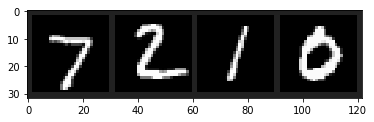

In [92]:
for data in test_loader:
    image, label = data
    show_image(torchvision.utils.make_grid(image))
    print(net(image).max(1)[1])
    break

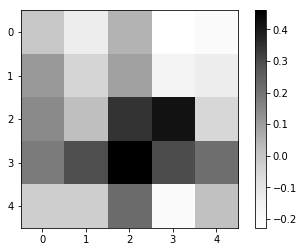

In [122]:
#Visualising one of the filters

plt.imshow(net.state_dict()['C1.weight'][1].numpy().squeeze(), cmap ='Greys')
plt.colorbar()